In [1]:
# Import packages 
import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import cv2

from tqdm.auto import tqdm
from ipywidgets import FloatProgress
from scipy import ndimage
from PIL import Image
from importlib import reload

# append path
sys.path.append('../')

# custom
import utils.BuildWNet as BuildWNet
from utils.GetLowestGPU import GetLowestGPU
from utils.WNetTileGenerator import TileGenerator
from utils.Metrics import iou
from utils.AreaCalc import area_calc
import utils.SegmentImage as SegmentImage
import utils.MeasureLeaves as MeasureLeaves

device = torch.device(GetLowestGPU(verbose=2))

---------------------------
 GPU | Memory-usage    
---------------------------
  0  | 00844MiB / 40537MiB
  1  | 06226MiB / 40537MiB
  2  | 00003MiB / 40537MiB
  3  | 06226MiB / 40537MiB
  4  | 00003MiB / 40537MiB
  5  | 00003MiB / 40537MiB
  6  | 00003MiB / 40537MiB
  7  | 02078MiB / 40537MiB
---------------------------
 Device set to cuda:2
---------------------------


# Import Best Model Weights

In [40]:
# Load model
# instantiate model
reload(BuildWNet)
wnet = BuildWNet.WNet(k = 4)

optE = torch.optim.Adam(wnet.U_encoder.parameters(), lr=1e-3)
optW = torch.optim.Adam(wnet.parameters(), lr=1e-3)

loss_function = torch.nn.CrossEntropyLoss()

In [41]:
# find iteration with lowest loss
log_path = '../logs/'
log = pd.read_csv(log_path + 'log.csv')
best_loss = log.iloc[log["val_loss"].idxmin()]["iter_num"].astype(int)
best_loss

6000

In [42]:
# load model weights
checkpoint = torch.load(f"../checkpoints/checkpoint_{best_loss}.pt", map_location=device)

#extract weights from checkpoint
weights = checkpoint["model"]

# trained model has been loaded
wnet.load_state_dict(weights)
wnet.eval() #inference mode (no dropout, batch norm uses running mean, etc.)
wnet.to(device)

WNet(
  (U_encoder): UNet(
    (hidden_activation): LeakyReLU(negative_slope=0.01)
    (enc_layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout2d(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout2d(p=0.1, inplace=False)
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.01)
      (11): Dropout2d(p=0.1, inplace=False)
      (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (13): Conv2d(64, 128, kernel_size=

# Load Images

In [43]:
# load in images
# options
image_path = "../data/test/images/"
mask_path = "../data/test/masks/"
save_path = "../data/test/predictions/"

# load image data
image_names = glob.glob(mask_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

# Create Predicted Segmentation Masks for Images

In [44]:
reload(SegmentImage)
SegmentImage.segment_image(model = wnet,
                           k = 4,
                           image_names = image_names,
                           image_path = image_path,
                           mask_path = mask_path,
                           save_path = save_path,
                           plot = True,
                           verbose = 2,
                           device = device)

Processing 1.tt8t x fc6-1.B.WBP-2022.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [45]:
# just plot tiles

# create list to store predicted segmentations so that we can count seeds later
inps = []
recs = []

# create list to store iou scores
wing_ious = []
env_ious = []
seed_ious = []

# loop over images
for image_name in image_names:
    print(f"Processing {image_name}")

    # load in image and convert to a numpy array
    image = Image.open(image_path + image_name)
    image = np.array(image) / 255.0

    mask = np.array(Image.open(mask_path + image_name))[:,:,:3] / 255.0

    # fix weird mask behavior - all px. values are 0 or 1
    mask[mask > 0] = 1

    # pad first 2 dimensions, (H, W) by 32 px
    image = np.pad(image,
                pad_width= ((32, 32), (32, 32), (0, 0)),
                mode='edge')

    # ensure each image is divisible by 128 by adding extra padding

    rpad = 128 - image.shape[0] % 128
    cpad = 128 - image.shape[1] % 128

    # do we really need this? or can we optimize?
    image = np.pad(image,
                pad_width=((0, rpad), (0, cpad), (0, 0)),
                mode='edge')

    ## BOOKKEEPING / PREDICTION

    # Double for loop over rows and columns with step size of 32 used for tile generation
    rows = range(0, image.shape[0]-(3*32), 32)
    cols = range(0, image.shape[1]-(3*32), 32)
    with tqdm(total=len(rows)*len(cols)) as pbar:
        for row in range(0, image.shape[0]-(3*32), 32): #don't index completely to the edge - otherwise, we will be indexing into a space that doesn't exist in the image
            for col in range(0, image.shape[1]-(3*32), 32):

                # select image tile
                tile = image[row:row+128, col:col+128]

                # make prediction and store the *center context* in global prb. map
                unet_input = torch.tensor(tile, dtype=torch.float32).to(device).permute(2, 0, 1).unsqueeze(0)
                prediction = wnet.forward_encoder(unet_input)
                rec = wnet.forward_decoder(prediction)

                inps.append(unet_input.permute(0, 2, 3, 1).squeeze().cpu().detach().numpy())
                recs.append(rec.permute(0, 2, 3, 1).squeeze().cpu().detach().numpy())

                pbar.update(1)

Processing 1.tt8t x fc6-1.B.WBP-2022.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Processing 10.tt8t x fc5-2.B.WBP-2022.W.png


  0%|          | 0/9265 [00:00<?, ?it/s]

Processing 9_5.tt8t x fc5-1.B.WBP-2022.W_rep2.png


  0%|          | 0/9265 [00:00<?, ?it/s]

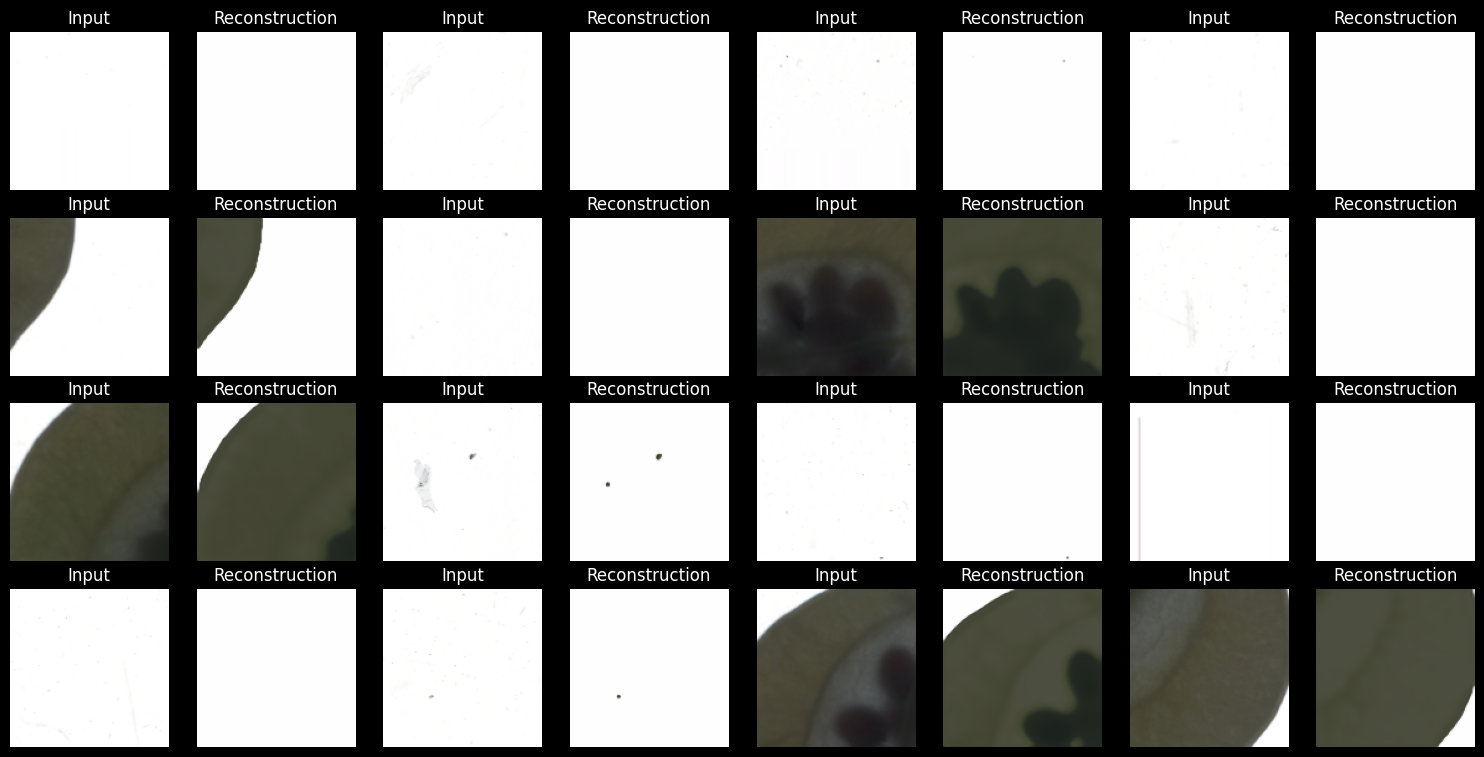

In [47]:
figsize = 15
fig = plt.figure(figsize=(figsize, figsize/2))
N=len(inps)
for i in range(16):
    idx = np.random.randint(0, N)
    fig.add_subplot(4, 8, 2*i+1)
    plt.imshow(inps[idx])
    plt.axis('off')
    plt.title('Input')
    fig.add_subplot(4, 8, 2*i+2)
    plt.imshow(recs[idx])
    plt.axis('off')
    plt.title('Reconstruction')

plt.tight_layout(pad=0.5)
plt.show()